## Краткое описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Цель проекта

Цель проекта - сокращение убытков заказчика, связанных с неэффективными акциями по удержанию клиентов (промо-купоны, скидки, пакеты услуг).

## План проекта
1. Загрузка данных
2. Первичное ознакомление, преобразование типов данных
3. Exploratory data analysis - анализ взаимосвязей признаков, составление первичого списка неважных признаков
4. Разбиение данных на обучающую и тестовые выборки
5. Составление шорт-листа моделей
6. Cold start моделей с полным набором признаков и без признаков, отобранных по результатам п. 3
7. Анализ feature importance, отделение неважных признаков, подбор гиперпараметров
8. Выбор лучшей модели и её проверка на тестовой выборке
9. Sanity check
10. Интерпретация результатов, подготовка отчёта


## Импорты библиотек

In [ ]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
#miscellaneous
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#analysis
import phik

#model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

#preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

#metrics and evaluation
from sklearn.metrics import mean_absolute_percentage_error, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from catboost import cv, Pool

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

## Загрузка данных

In [ ]:
contracts = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Первичное ознакомление с данными, предобработка

### Датафрейм contracts

In [ ]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contracts['customerID'].duplicated().sum()

0

- Пропусков нет
- Дубликатов в ID пользователей нет
- Необходимо преобразовать типы данных
  - `BeginDate` и `EndDate` к `datetime`
  - `TotalCharges` к `float`

In [ ]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'], format = '%Y-%m-%d')
contracts['BeginDate'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

In [ ]:
contracts['EndDate'].value_counts(normalize = True)

No            0.843675
2020-01-01    0.005537
2019-12-01    0.005395
2018-11-01    0.004969
2019-09-01    0.004544
                ...   
2014-09-01    0.000284
2014-12-01    0.000284
2014-06-01    0.000142
2014-10-01    0.000142
2014-11-01    0.000142
Name: EndDate, Length: 67, dtype: float64

А вот и наш целевой признак. Для пользователей, у которых нет конечной даты, будет назначен класс 0, для остальных - 1 (сразу отмечу сильный дисбаланс классов, с которым предстоит бороться на этапе обучения)

In [ ]:
contracts['Churn'] = (contracts['EndDate'] != 'No')
1 - contracts['Churn'].mean()

0.8436745704955275

Целевой признак выделен. Теперь можно преобразовать признак к типу `datetime`, заменив значения `No` на `Nat`

In [ ]:
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'], format = '%Y-%m-%d', errors = 'coerce')

Признак `TotalCharges` - строковый. Обычно такое случается, если в столбце присутствуют нечисловые записи (' ', 'None' и т.д.).

In [ ]:
contracts[~contracts['TotalCharges'].str.contains('.', regex = False)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,False
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,False
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,False
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,False
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,False
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,False
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,False
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,False
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,False
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,False


В признаке содержатся пропуски. Пропущены данные у пользователей, которые только что заключили договоры, поэтому эти пропуски можно заполнить нулями.

In [ ]:
contracts['TotalCharges'] = contracts['TotalCharges'].replace(' ', None).astype(float).fillna(0)

In [ ]:
contracts[contracts['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.0,False
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.0,False
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.0,False
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,0.0,False
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,0.0,False
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,0.0,False
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,0.0,False
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.0,False
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.0,False
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,0.0,False


Признаки `Type`, `PaperlessBilling` и `PaymentMethod` - категориальные. Посмотрим на значения, которые в них хранятся

In [ ]:
contracts['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
contracts['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
contracts['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Всё чисто, никаких подозрительных значений ('None' и прочее) нет.

### Датафрейм personal

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal['customerID'].duplicated().sum()

0

- Пропусков нет
- Дубликатов в ID пользователей нет
- Количество записей совпадает с `contracts`
- Для анализа преобразуем тип данных признака `SeniorCitizen` к строковому со значениями 'Yes' и 'No' (но вначале убедимся, что других значений, кроме 0 и 1 там нет)

In [ ]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace([0, 1], ['No', 'Yes'])
personal['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

Все признаки в датасете - категориальные. Посмотрим на их уникальные значения

In [ ]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Всё в порядке, ошибочных значений нет

### Датафрейм internet

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet['customerID'].duplicated().sum()

0

- Пропусков нет
- Дубликатов в ID пользователей нет
- Количество записей меньше, чем `contracts` и `personal`, что логично - не все клиенты используют интернет
- Преобразование типов не требуется, просто изучим уникальные значения категориальных признаков

In [ ]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [ ]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

Всё в порядке, ошибочных значений нет

### Датафрейм phone

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone['customerID'].duplicated().sum()

0

- Пропусков нет
- Дубликатов в ID пользователей нет
- Количество записей меньше, чем `contracts` и `personal`, что логично - не все клиенты используют телефон
- Преобразование типов не требуется, просто изучим уникальные значения категориальных признаков

In [ ]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Всё в порядке, ошибочных значений нет

### Объединение данных и обработка образовавшихся пропусков

Объединим признаки в один датафрейм. В итоговом датафрейме должно быть столько же строк, сколько и в contracts, а столбцов - столько же, сколько признаков во всех датафреймах вместе (за исключением `customerID`, который мы установим как индекс, чтобы использовать `join`)

In [ ]:
(contracts.shape[0], contracts.shape[1] + personal.shape[1] + internet.shape[1] + phone.shape[1] - 4)

(7043, 20)

In [ ]:
df = contracts.set_index('customerID').join(
    [personal.set_index('customerID'),
     internet.set_index('customerID'),
     phone.set_index('customerID')])

In [ ]:
df.shape

(7043, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1101 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   bool          
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

В итоговом датафрейме образовались пропуски. Заполним их значениями 'No' за исключением трёх:
- В `MultipleLines` и `InternetService` заполним пропуски значениями 'Not used' - так мы отличим тех, кто не пользуется несколькими линиями от тех, кто не пользуется телефоном вообще.

- Пропуски в EndDate заполним "сегодняшней" датой, чтобы расчитать длительность обслуживания клиентов.

In [ ]:
df[['MultipleLines', 'InternetService']] = df[['MultipleLines', 'InternetService']].fillna('Not used')
df.loc[:,'InternetService':] = df.loc[:,'InternetService':].fillna('No')

In [ ]:
df['EndDate'] = df['EndDate'].fillna(pd.to_datetime('2020-02-01', format = '%Y-%m-%d'))
df = df.fillna('Not used')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   bool          
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

In [ ]:
df['BeginDate']

customerID
7590-VHVEG   2020-01-01
5575-GNVDE   2017-04-01
3668-QPYBK   2019-10-01
7795-CFOCW   2016-05-01
9237-HQITU   2019-09-01
                ...    
6840-RESVB   2018-02-01
2234-XADUH   2014-02-01
4801-JZAZL   2019-03-01
8361-LTMKD   2019-07-01
3186-AJIEK   2014-08-01
Name: BeginDate, Length: 7043, dtype: datetime64[ns]

Расчитаем новый признак - продолжительность обслуживания клиента в днях

In [ ]:
df['ServiceDuration'] = (df['EndDate'] - df['BeginDate']).dt.days
df[['BeginDate', 'EndDate', 'ServiceDuration']].head()

,BeginDate,EndDate,ServiceDuration
customerID,,,
7590-VHVEG,2020-01-01,2020-02-01,31
5575-GNVDE,2017-04-01,2020-02-01,1036
3668-QPYBK,2019-10-01,2020-02-01,123
7795-CFOCW,2016-05-01,2020-02-01,1371
9237-HQITU,2019-09-01,2020-02-01,153


## EDA

### Анализ распределений признаков

Изучим распределения числовых признаков

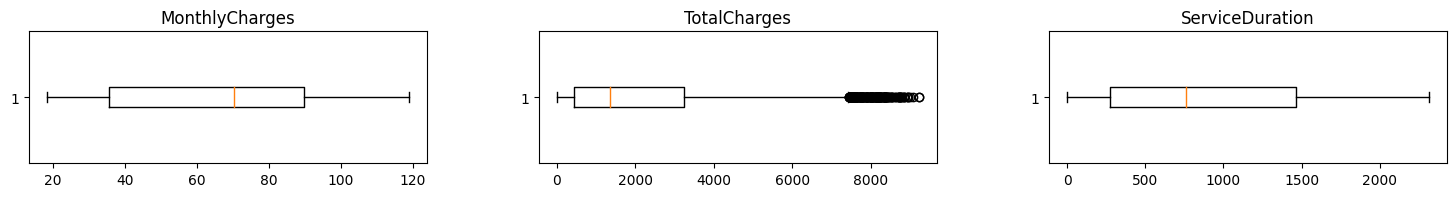

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
fig.tight_layout(pad=5.0)
num_features = ['MonthlyCharges', 'TotalCharges', 'ServiceDuration']
for i in range(3):
    axes[i].boxplot(df[num_features[i]], vert = False)
    axes[i].set_title(num_features[i])
plt.show();

Видно что в `TotalCharges` имеется "хвост" справа. В `MonthlyCharges` и `ServiceDuration` выбросов нет.

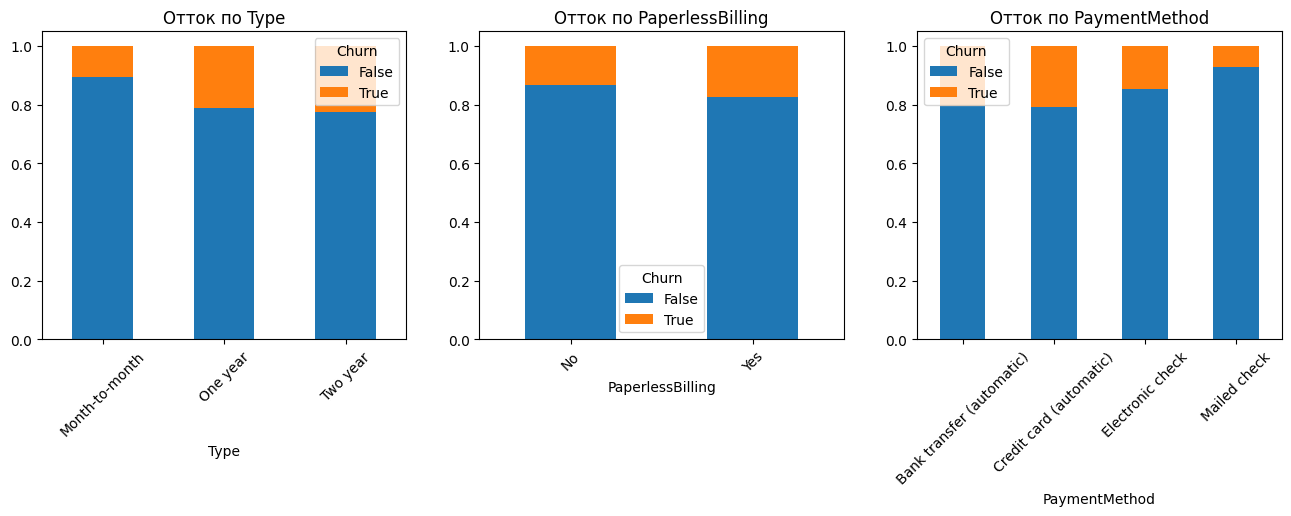

In [ ]:
def draw_barchart(column, ax):
    return df.groupby(column)['Churn'].value_counts(normalize = True).unstack().\
    plot(kind = 'bar', stacked = True, title = f'Отток по {column}', ax = ax, rot = 45)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
draw_barchart('Type', ax = axes[0])
draw_barchart('PaperlessBilling', ax = axes[1])
draw_barchart('PaymentMethod', ax = axes[2])
plt.show()

- Клиенты, которые заключает долгосрочные договоры, уходят чаще, чем те, кто заключает ежемесячные
- Криенты, которым счета выставляют по электронной почте уходят немного чаще
- Клиенты, которым получают счета по обычной почте уходят значительно реже

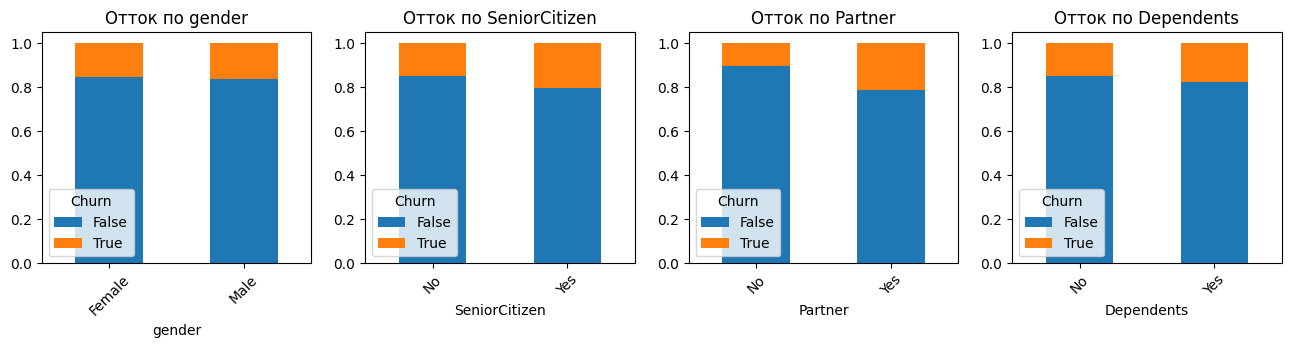

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
draw_barchart('gender', ax = axes[0])
draw_barchart('SeniorCitizen', ax = axes[1])
draw_barchart('Partner', ax = axes[2])
draw_barchart('Dependents', ax = axes[3])
plt.show()

- Клиенты обоих полов уходят примерно одинаково
- Пенсионеры уходят чаще
- Одинокие люди уходят значительно реже
- Наличие иждевенцев на отток практически не влияет

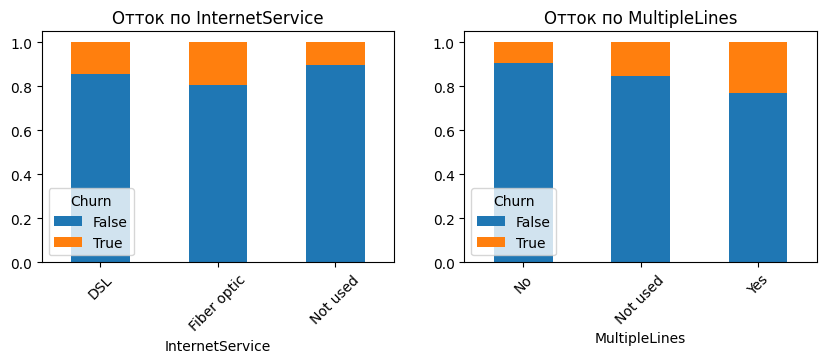

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
draw_barchart('InternetService', ax = axes[0])
draw_barchart('MultipleLines', ax = axes[1])
plt.show()

- Клиенты, не использующие интернет уходят реже
- Клиенты, которые пользуются телефоном, но не используют несколько линий, уходят реже, чем те, кто этой услугой пользуется

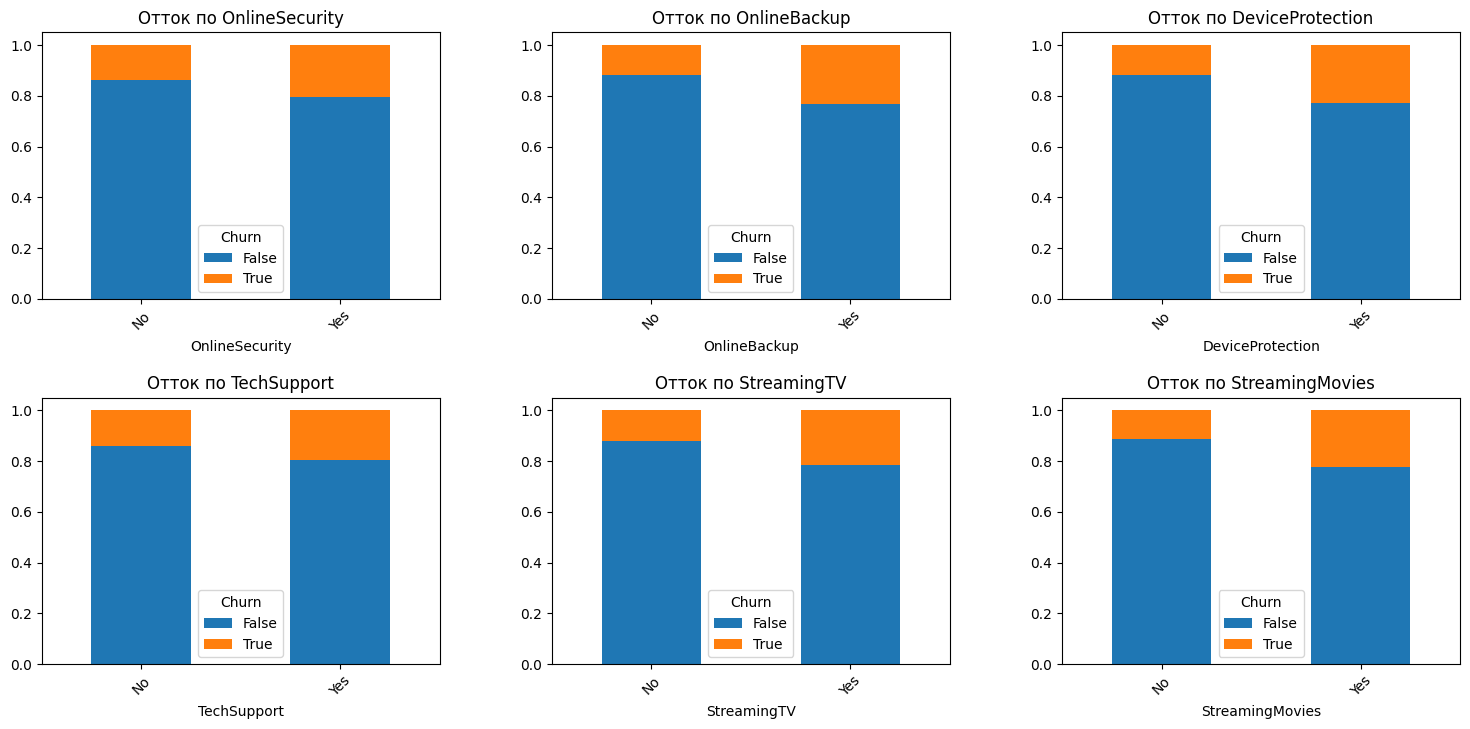

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.tight_layout(pad=5.0)
draw_barchart('OnlineSecurity', ax = axes[0, 0])
draw_barchart('OnlineBackup', ax = axes[0, 1])
draw_barchart('DeviceProtection', ax = axes[0, 2])
draw_barchart('TechSupport', ax = axes[1, 0])
draw_barchart('StreamingTV', ax = axes[1, 1])
draw_barchart('StreamingMovies', ax = axes[1, 2])
plt.show()

Клиенты, использующие любую дополнителньую услугу уходят чаще

### Анализ матрицы корреляций

Рассмотрим матрицу корреляции признаков. Будем обращать внимание на связь признаков с целевым, а также на их связь между собой. Постепенно будем удалять признаки, имеющие низкую связь с целевым и/или высокую взаимосвязь.

Важно - получившийся список не стоит рассматривать как окончательное решение о том, какие признаки не важны. Окончательное решение будет приниматься после запуска моделей и анализа важности признаков.

In [ ]:
features_to_drop_EDA = ['BeginDate', 'EndDate']
interval_features = ['MonthlyCharges', 'TotalCharges', 'ServiceDuration']

In [ ]:
def redraw_corr(to_drop, interval):
  phik_corr = df.drop(to_drop, axis = 1).phik_matrix(interval_cols = interval)
  fig, ax = plt.subplots(figsize=(15, 8))
  sns.heatmap(phik_corr, cmap='coolwarm', annot = True)

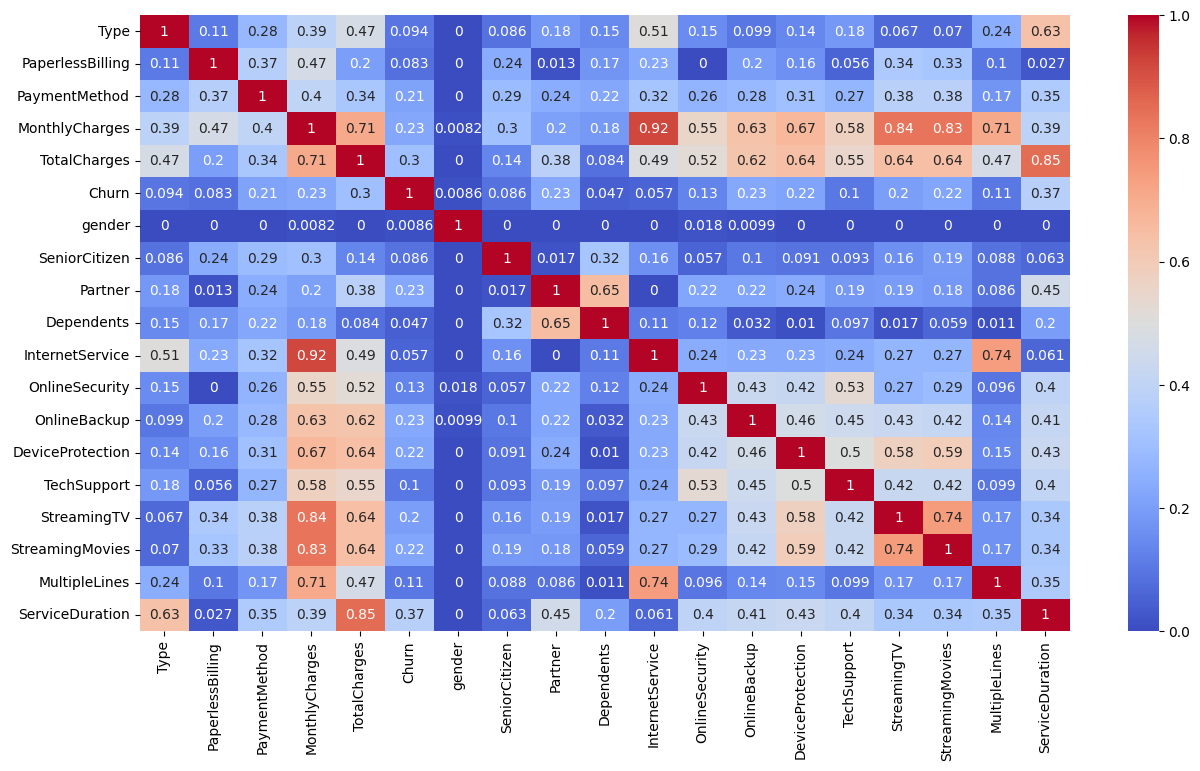

In [ ]:
redraw_corr(features_to_drop_EDA, interval_features)

Сразу бросается в глаза то, что признак `Gender` слабо связан с остальными (в том числе и с целевым)

In [ ]:
features_to_drop_EDA.append('gender')

Признаки `MonthlyCharges`, `TotalCharges` и `ServiceDuration` связаны между собой. По большому счёту - `TotalCharges` это произведение `MonthlyCharges` и `ServiceDuration` (с погрешностью на то, что ежемесячная плата может меняться с течением времени). Проверим это, посчитав среднюю абсолютную ошибку в процентах

In [ ]:
mean_absolute_percentage_error(df['TotalCharges'], df['ServiceDuration'] * df['MonthlyCharges'] / 30)

0.027052559817000617

Таким образом, `TotalCharges` - это линейная комбинация `MonthlyCharges` и `ServiceDuration`.

In [ ]:
features_to_drop_EDA.append('TotalCharges')

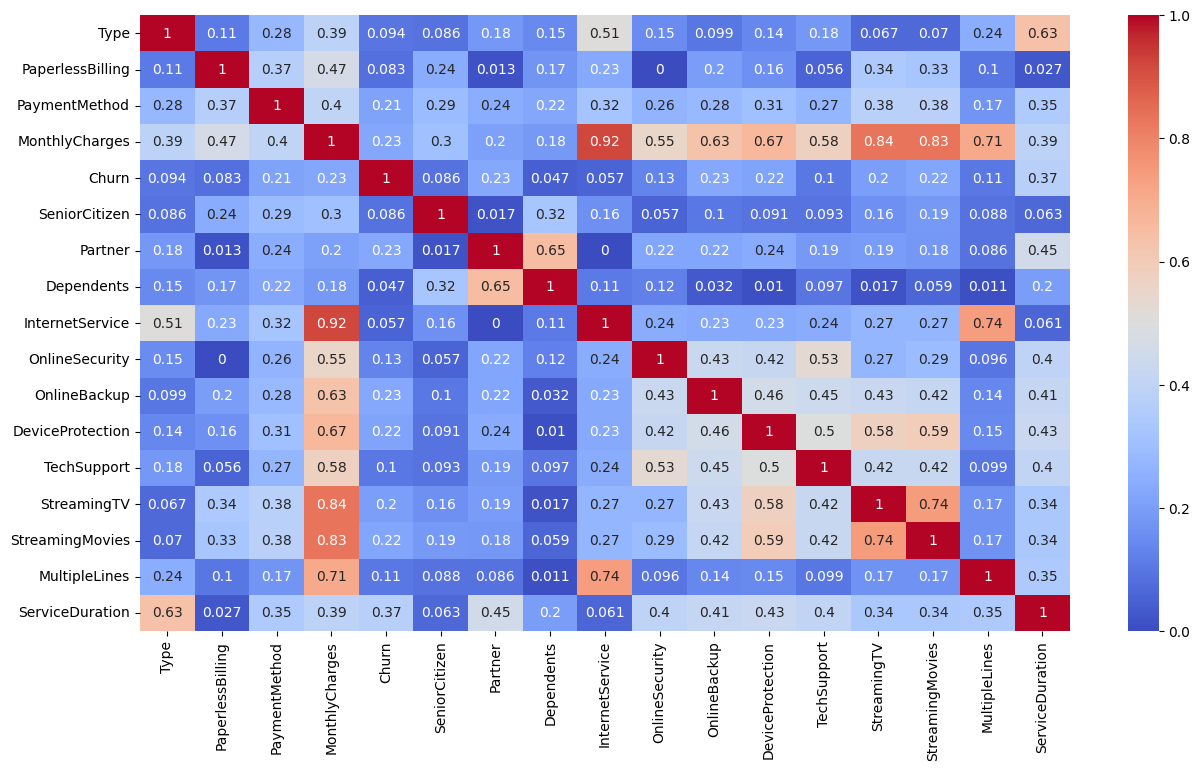

In [ ]:
redraw_corr(features_to_drop_EDA, interval_features)

Из оставшихся признаков выделяется `InternetService` по нескольким причинам
- Он имеет очень сильную связь с `MonthlyCharges`, а также с признаками использования дополнительных услуг, связанных с интернетом (что логично)
- Он имеет очень слабую связь с целевым принзнаком (0.057 - почти самый низкий показатель из оставшихся признаков)

Аналогичная ситуация с признаками `Partner` и `Dependents`. Удалим второй, т.к. `Partner` имеет более высокую корреляцию с целевым признаком.

Возможно имеет смысл удалить признак `InternetService`. Конечное решение отложу до первых запусков моделей и анализа важности признаков.

In [ ]:
features_to_drop_EDA.append('Dependents')
features_to_drop_EDA.append('InternetService')

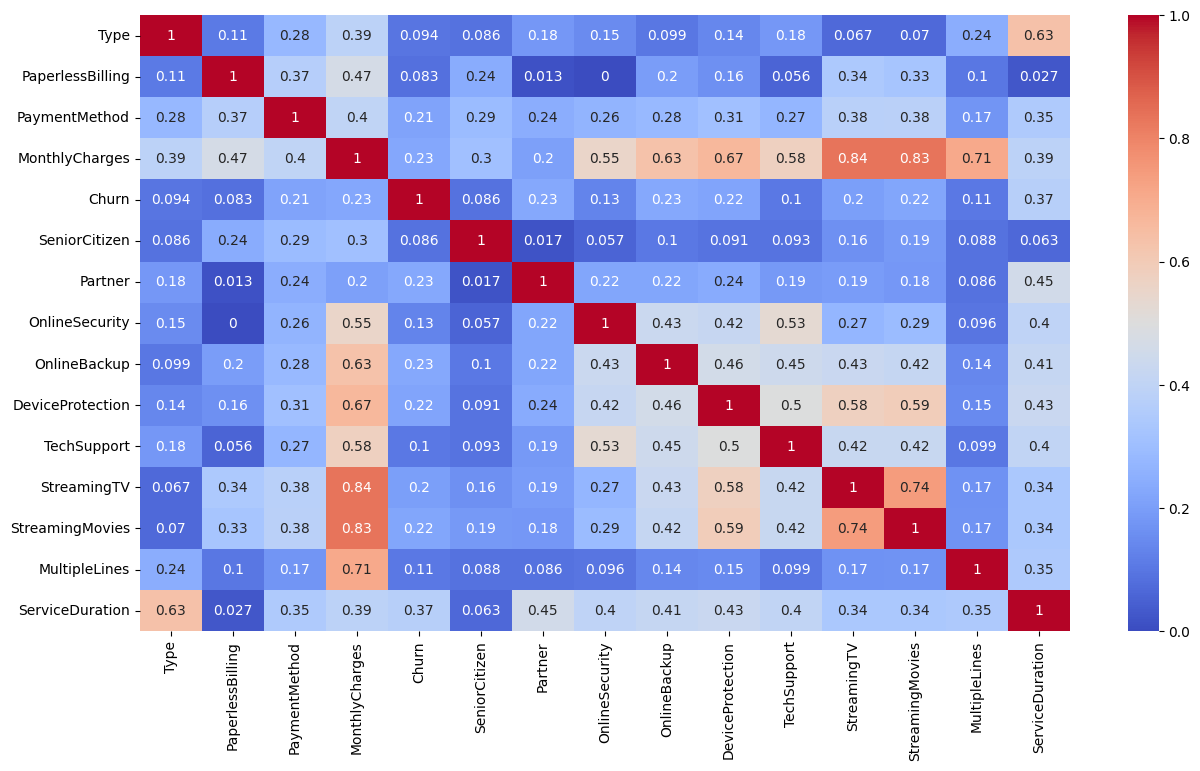

In [ ]:
redraw_corr(features_to_drop_EDA, interval_features)

## Промежуточные итоги

Выполнены п.1-3 плана:
- данные загружены без ошибок
- произведена обработка пропусков и объединение данных в один датафрейм
- исследована взаимосвязь признаков, на данном этапе предполагается удалить следующие признаки:
  - даты заключения и расторжения договоров
  - пол
  - общие затраты
  - наличие иждевенцев
  - наличие услуг Интернет

## Моделирование

### Подготовка данных

Зададим random_state для моделирования

In [ ]:
RANDOM_STATE = 2102023

Подготовим списки фичей

In [ ]:
y = 'Churn'
X = df.columns.drop([y, 'BeginDate', 'EndDate'])
X

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'ServiceDuration'],
      dtype='object')

Отдельно подготовим списки категориальных и числовых фичей

In [ ]:
X_numeric = ['MonthlyCharges', 'ServiceDuration', 'TotalCharges']

In [ ]:
X_categorial = X.drop(X_numeric)
X_categorial

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object')

Разобьём данные на стратифицированные тестовую и обучающие выборки в соотношении 3:1,

In [ ]:
train, test = train_test_split(df, test_size = 0.25, random_state = RANDOM_STATE, stratify = df[y])

Проверим соотношение выборок, а также соблюдение баланса классов

In [ ]:
train.shape[0] / test.shape[0], df[y].mean(), train[y].mean(), test[y].mean()

(2.9994321408290743,
 0.15632542950447254,
 0.1563801590306702,
 0.15616127200454288)

Разбиение в норме

<div class="alert alert-block alert-success">
✔️ <b>Ревью 3</b>: Да )
</div>

### Выбор моделей

Предлагаю использовать 3 модели:
- логистическую регрессию
- случайный лес
- градиентный бустинг (библиотека CatBoost).

Для удобства работы с несколькими моделями создадим класс, в котором будут храниться данные моделирования.
Класс содержит следующие методы:
- `add_features` - добавляет списки числовых и категориальных признаков
- `add_pipeline` - принимает в качестве аргументов список шагов для обработки данных с указанием типа переменных (числовые/категориальные) и модель. Создаёт пайплайн, состоящий из трансформера с указанными шагами и модели
- `update_features` - обновляет список признаков и обновляет пайплайн с новыми признакми
- `add_search_params` - добавляет словарь параметров для гридсёрча
- `make_importance_df` - создаёт датафрейм, хранящий список признаков, значения их важности и ранг важности
- `get_important` - возвращает указанное количество признаков, отсортированных по рангу важности (возвращает наиболее важные, при most = True и наименее важные в противном случае)
- `search` - запускает гридсёрч с заданными параметрами, сохраняет его результаты и вызывает метод `make_importance_df`

In [ ]:
class modelling_results:
  def __init__(self, name):
    self.name = name

  def add_features(self, X_numeric, X_categorial):
    self.X_numeric = X_numeric
    self.X_categorial = X_categorial
    self.X = X_numeric + list(X_categorial)

  def add_pipeline(self, preprocessing_steps, model):
    if preprocessing_steps is not None:
      self.preprocessing_steps = preprocessing_steps
      self.model = model
      preprocessing = []

      for step in preprocessing_steps:
        if step[2] == 'num':
          preprocessing.append((step[0], step[1], self.X_numeric))
        else:
          preprocessing.append((step[0], step[1], self.X_categorial))
      self.pipeline = Pipeline(
          [
              ('transformer', ColumnTransformer(preprocessing)),
              ('model', self.model)
          ])
    else:
      self.pipeline = model

  def update_features(self, new_numeric, new_categorial):
    self.add_features(new_numeric, new_categorial)
    self.add_pipeline(self.preprocessing_steps, self.model)

  def add_search_params(self, params):
    self.search_parameters = params

  def make_iportance_df(self, silent = True):
    try:
      self.importance = pd.DataFrame(
          zip(self.search_results.best_estimator_.named_steps['model'].coef_[0]),
          self.search_results.best_estimator_[:-1].get_feature_names_out(), columns = ['importance'])
    except:
      if isinstance(self.pipeline, CatBoostClassifier):
         self.importance = pd.DataFrame(
            zip(self.search_results.best_estimator_.feature_importances_),
            self.search_results.best_estimator_.feature_names_, columns = ['importance'])
      else:
        self.importance = pd.DataFrame(
            zip(self.search_results.best_estimator_.named_steps['model'].feature_importances_),
            self.search_results.best_estimator_[:-1].get_feature_names_out(), columns = ['importance'])

    self.importance['rank'] = self.importance.abs().rank(ascending = False)['importance']
    if not silent:
      return self.importance

  def get_important(self, num, most = True):
    return self.importance.sort_values(by = 'rank', ascending = most).head(num)

  def search(self, X, y, folds = 3):
    metrics = []
    skf = StratifiedKFold(n_splits = folds)
    self.search_results = GridSearchCV(estimator = self.pipeline, param_grid = self.search_parameters, scoring = ['roc_auc', 'accuracy'], refit = 'roc_auc', cv = skf)
    self.search_results.fit(X, y)
    self.search_scores = pd.DataFrame(self.search_results.cv_results_)[['params', 'mean_test_roc_auc', 'rank_test_roc_auc', 'mean_test_accuracy', 'rank_test_accuracy']]
    self.make_iportance_df()

  def get_final_scores(self):
    best = self.search_scores[self.search_scores['mean_test_roc_auc'] == self.search_scores['mean_test_roc_auc'].max()]
    return pd.Series([best['mean_test_roc_auc'].values[0], best['mean_test_accuracy'].values[0]], index = ['ROC-AUC', 'Accuracy'], name = self.name)

### Логистическая регрессия

#### Подготовка данных

Для логистической регрессии, как и для любой другой линейной модели требуется провести масштабирование числовых признаков. Кроме того, необходимо кодировать категориальные признаки. Масштабирование выполним с помощью StandardScaler, кодирование с помощью OneHotEncoder.

In [ ]:
log_regression = modelling_results('Логистическая регрессия')

In [ ]:
log_regression.add_features(X_numeric, X_categorial)

In [ ]:
log_regression.add_pipeline(
    preprocessing_steps = [
        ["scaler", StandardScaler(), 'num'],
        ["encoder", OneHotEncoder(drop = 'first'), 'cat']],
    model = LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced'))

#### Обучение модели

In [ ]:
log_regression.add_search_params ({
    'model__solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
    'model__C' : np.arange(0.1, 1.1, 0.1)
    })

In [ ]:
log_regression.search(train[log_regression.X], train[y])

Лучший набор гиперпараметров:

In [ ]:
log_regression.search_results.best_params_

{'model__C': 0.2, 'model__solver': 'sag'}

In [ ]:
log_regression.get_final_scores()

ROC-AUC     0.756560
Accuracy    0.695381
Name: Логистическая регрессия, dtype: float64

Лучшее значение ROC-AUC - 0.75, что ниже порогового (0.85)

### RandomForest

#### Подготовка данных

Масштабирование для случайного леса не нужно, поэтому в пайплайне оставляем только кодирование категориальных признаков, для которого используем OrdinalEncoder

In [ ]:
random_forest = modelling_results('Случайный лес')
random_forest.add_features(X_numeric, X_categorial)
random_forest.add_pipeline(
    preprocessing_steps = [
        ["encoder", OrdinalEncoder(), 'cat']],
    model = RandomForestClassifier(random_state = RANDOM_STATE, class_weight = 'balanced'))

#### Обучение модели

In [ ]:
random_forest.add_search_params(
    {
        'model__n_estimators' : range(100, 131),
        'model__max_depth' : range(1, 11),
    }
)

In [ ]:
random_forest.search(train[random_forest.X], train[y])

Лучшая модель:

In [ ]:
random_forest.search_results.best_params_

{'model__max_depth': 5, 'model__n_estimators': 119}

In [ ]:
random_forest.get_final_scores()

ROC-AUC     0.712094
Accuracy    0.655436
Name: Случайный лес, dtype: float64

Лучшее значение ROC-AUC - 0.71, что ниже порогового (0.85)

### Catboost

#### Подготовка данных

CatBoost не требует масштабироования или кодирования признаков

In [ ]:
catboost = modelling_results('CatBoost')
catboost.add_features(X_numeric, X_categorial)

cb_params = {
             'loss_function': 'Logloss',
             'eval_metric' : 'AUC',
             'random_seed': RANDOM_STATE,
             'iterations' : 2000,
             'verbose': False}

catboost.add_pipeline(
    preprocessing_steps = None,
    model = CatBoostClassifier(cat_features = list(X_categorial), **cb_params))

catboost.add_search_params ({
    'depth' : range(1, 5),
    'learning_rate' : np.arange(0.10, 0.16, 0.1)
    })

#### Обучение модели

In [ ]:
catboost.search(train[catboost.X], train[y].astype(int))

Лучшая модель:

In [ ]:
catboost.search_results.best_params_

{'depth': 2, 'learning_rate': 0.1}

In [ ]:
catboost.get_final_scores()

ROC-AUC     0.910797
Accuracy    0.912913
Name: CatBoost, dtype: float64

Лучшее значение ROC-AUC - 0.91, что выше порогового (0.85)

### Выбор и проверка лучшей модели

In [ ]:
models_scores = pd.DataFrame([log_regression.get_final_scores(), random_forest.get_final_scores(), catboost.get_final_scores()])
models_scores

,ROC-AUC,Accuracy
Логистическая регрессия,0.756560,0.695381
Случайный лес,0.712094,0.655436
CatBoost,0.910797,0.912913


Наилучшие результаты показывает CatBoost. Проверим модель на тестовой выборке

In [ ]:
predictions = catboost.search_results.best_estimator_.predict_proba(test[catboost.X])[:, 1]

In [ ]:
roc_auc_score(test[y], predictions)

0.9346641380154167

На тестовой выборке ROC-AUC составляет 0.93, что выше порогового (0.85).

### Sanity check

In [ ]:
dummy = DummyClassifier(strategy = 'prior')
dummy.fit(train[X], train[y])
roc_auc_score(test[y], dummy.predict_proba(test[X])[:, 1]), accuracy_score(test[y], dummy.predict(test[X]))

(0.5, 0.8438387279954571)

Результаты по обоим метрикам ниже, чем у итоговой модели. Sanity check пройден

## Анализ и интерпретация результатов моделирования

### ROC-кривая

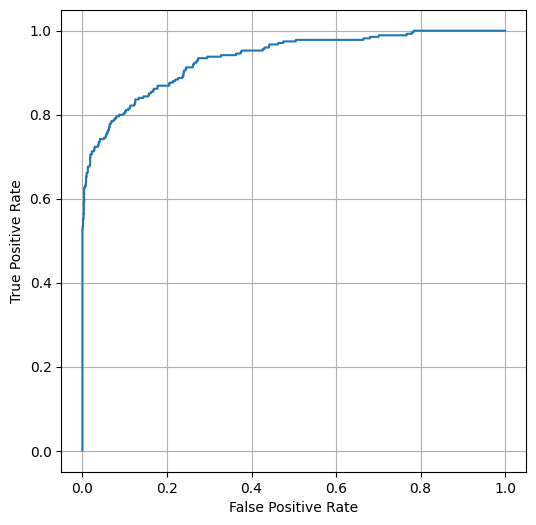

In [ ]:
fpr, tpr, thresholds = roc_curve(test[y], predictions)
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax = ax)
plt.grid()
plt.show()

ROC-кривая показывает, что оптимальна, с точки зрения поддержания одновременно высокого TPR и низкого FPR точка находится примерно в районе FPR=0.2

In [ ]:
roc_data = pd.DataFrame(zip(fpr, tpr), index = thresholds, columns = ['fpr', 'tpr'])
suggested_threshold = roc_data[roc_data['fpr'] <= 0.2].sort_values(by = 'tpr', ascending = False).head(1).index.values[0]
suggested_threshold

0.13348924344307006

### Матрицы ошибок

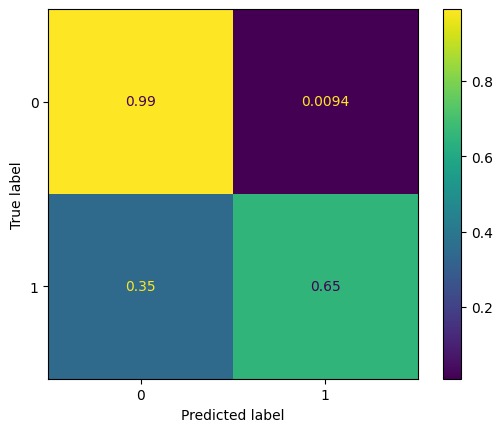

In [ ]:
cm = confusion_matrix(test[y], catboost.search_results.best_estimator_.predict(test[catboost.X]), normalize = 'true')
cm_display = ConfusionMatrixDisplay(cm).plot()

Матрица ошибок показывает, что при дефолтном пороге модель верно угадывает уходящего клиента с вероятностью около 50%. Наша модель получилась довольно "осторожной", в таком виде бОльшая часть выделенного на удержание клиента бюджета попадёт в цель, однако почти половина уходящих клиентов останется без внимания.

Такая стратегия подойдёт, если бюджет на удержание невелик, но не очень подходит, если цель бизнеса - удержание всех клиентов.

В качестве примера продемонстрируем как изменение порога влияет на предсказания

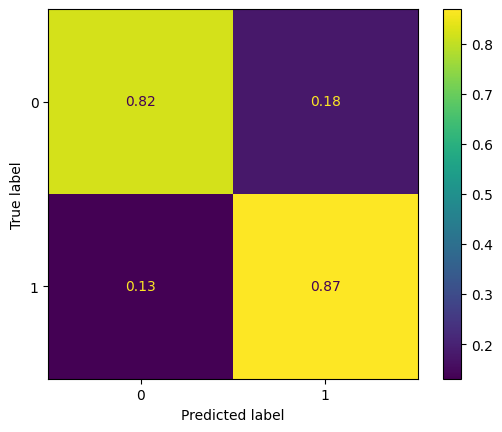

In [ ]:
cm = confusion_matrix(test[y], predictions >= suggested_threshold, normalize = 'true')
cm_display = ConfusionMatrixDisplay(cm).plot()

При применении предложенного порога, модель становится куда менее осторожной и процент верно угаданных уходящих пользователей становится значительно выше. Вместе с этим, процент верно угаданных остающихся клиентов падает, а это значит, что компания тратит большн денег на неэффективные ации по удержанию.

Итоговый выбор порога остаётся за заказчиком исследования, исходя из его целей и бюджета.

### Анализ важности признаков

<Axes: >

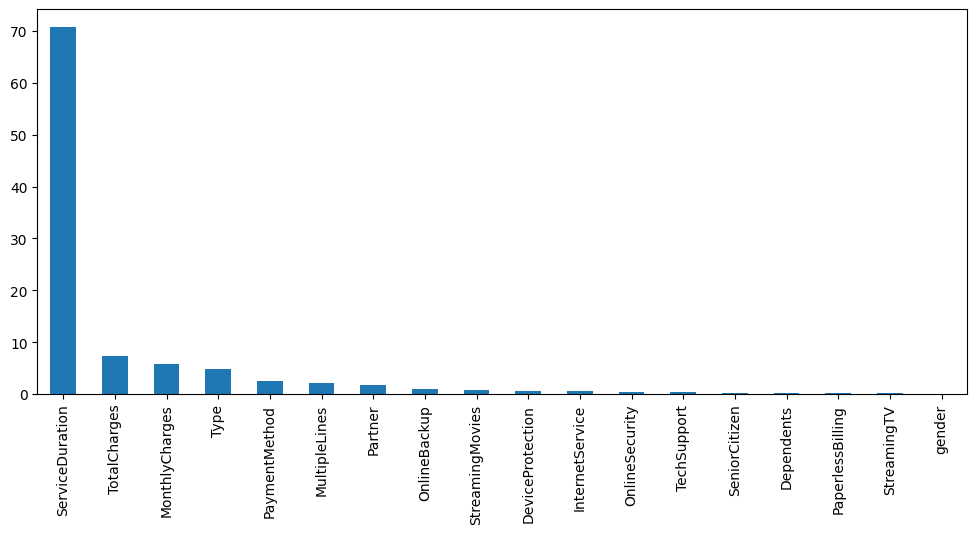

In [ ]:
catboost.importance['importance'].sort_values(ascending = False).plot(kind = 'bar', figsize = (12, 5))

Наиболее важным признаком модель считает добавленную нами продолжительность обслуживания. Кроме того, довольно важными оказались общие и ежемесячные траты. Менее важные, но всё ещё значимые - тип договора, способ оплаты и использование телефона. Остальные признаки имеют очень малую значимость.

## Промежуточные итоги по этапу моделирования

Выполнены п.4-9 (и частично 10) плана.
- Данные разбиты на выборки в заданном соотношении 3:1
- Для работы выбраны модели логистической регрессии, случайного леса и градиентного бустинга
- Выполнено моделирование (удаление признаков, отобранных по результатам EDA или по результатам первичного анализа важности привело к ухудшению качества, поэтому в итоговом варианте все модели работали м полным набором признаков)
- На кросс-валидации выбрана модель градиентного бустинга (CatBoost) со значением ROC-AUC = 0.91
- Модель проверена на обучающей выборке, итоговое значение ROC-AUC = 0.93
- Проведён анализ ROC-кривой и матрицы ошибок
- Выделены наиболее значимые признаки - продолжительность обслуживания, общие и ежемесячные траты

## Отчёт

Вспомним план проекта и сравним итоговое решение с ним

- [x] Загрузка данных - выполнено
- [x] Первичное ознакомление, преобразование типов данных - выполнено
- [x] Exploratory data analysis - анализ взаимосвязей признаков, составление первичого списка неважных признаков - выполнено
- [x] Разбиение данных на обучающую и тестовые выборки - выполнено
- [x] Составление шорт-листа моделей - выполнено
- [x] Cold start моделей с полным набором признаков и без признаков, отобранных по результатам п. 3 - выполнено
- [x] Анализ feature importance, отделение неважных признаков, подбор гиперпараметров - выполнено частично (feature selection результатов не дал, поэтому в итоговую работу не включён)
- [x] Выбор лучшей модели и её проверка на тестовой выборке - выполнено
- [x] Sanity check - выполнено
- [ ] Интерпретация результатов, подготовка отчёта - в процессе

### Исследование данных

Произведена загрузка и предобработка данных:
- данные проверены на пропуски и дубликаты
- произведено изменение типов данных
- данные объединены в один датафрейм, образовавшиеся при этом пропуски заполнены
- добавлен новый признак - продолжительность обслуживания в днях

Проведён разведочный анализ данных:
- исследованы распределения категориальных и численных признаков
  - выявлено что распределение общих трат сильно скошено влево
  - клиенты, которые заключает долгосрочные договоры, уходят чаще, чем те, кто заключает ежемесячные
  - клиенты, использующие безналичные способы оплаты уходят чаще
  - не выявлено сильной зависимости между оттоком и такими признаками как пол, возраст, наличие семьи
  - процент оттока выше среди пользователей, использующих любые дополнительные услуги
- проведён анализ матрицы корреляций


### Моделирование

- Данные разбиты на обучающую и тестовую выборки в соотношении 3:1
- Для работы выбраны модели логистической регрессии, случайного леса и градиентного бустинга
- Для каждой из моделей выполнен подбор гиперпараметров и расчёт метрик ROC-AUC и accuracy на кросс-валидации, наилучшие результаты представлены в таблице ниже

In [ ]:
models_scores

,ROC-AUC,Accuracy
Логистическая регрессия,0.756560,0.695381
Случайный лес,0.712094,0.655436
CatBoost,0.910797,0.912913


Гиперпараметры лучшей модели:

In [ ]:
catboost.search_results.best_params_

{'depth': 2, 'learning_rate': 0.1}

- Заданный порог ROC-AUC > 0.85 преодолела только модель градиентного бустинга (CatBoost) со значением ROC-AUC = 0.91
- Модель проверена на обучающей выборке, итоговое значение ROC-AUC = 0.93
- Проведён анализ ROC-кривой и матрицы ошибок
- Выделены наиболее значимые признаки - продолжительность обслуживания, общие и ежемесячные траты

### Рекомендации по эксплуатации модели

С дефолтным порогом классификации (0.5) модель верно угадывает около половины уходящих пользователей. Во время эксплуатации рекомендуется подбирать порог с учётом бюджета на рекламные акци, ориентируясь на метрики бизнеса:
- если бюджет невелик, то порог можно завысить (>0.5), таким образом модель будет выбирать только тех пользователей в уходе которого она максимально уверена
- если есть цель удержать максимальное количество клиентов, то его можно занизить (<0.5), таким образом рекламные акции будут предложены бОльшему количеству клиентов